# Eigenfaces for Recognition

## Defining the Facespace

First, let's import all we need and set some useful variables and functions.

In [1]:
import numpy as np
import numpy.linalg as la
from numpy.random import default_rng
from ipywidgets import interact, interactive, fixed
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from mpl_toolkits.axes_grid1 import ImageGrid

rng = default_rng()

N = 92
M = 112
NM = N * M
training_dir = "./att_faces/Training"
testing_dir = "./att_faces/Testing"

def get_training_path_to_img(id: int, number: int):
    return training_dir + "/s" + str(id) + "/" + str(number) + ".pgm"

def get_testing_path_to_img(id: int):
    return testing_dir + "/s" + str(id) + "/" + str(id) + ".pgm"

# Returns a 1D array with the image data
def get_img(path: str):
    image = imread(path)
    return np.array(image, dtype = float).flatten()

def render_images(images: np.ndarray):
    fig = figure(figsize=(M, N))    
    nr_imgs = images.shape[1]
    
    rows = nr_imgs // 10 if nr_imgs % 10 == 0 else nr_imgs // 10 + 1
    
    grid = ImageGrid(fig, 111, 
                nrows_ncols=(rows, 12),
                axes_pad=0.1,  # pad between axes
                )
    for ax, im in zip(grid, images.T):
        ax.imshow(im.reshape(M, N), cmap = 'Greys_r')
        ax.axis('off')
        
def render_image(image):
    imshow(image, cmap = 'Greys_r')
    axis('off')

Every image can be seen as a matrix with *M* rows and *N* columns. We shall collapse this matrix into a single vector with *M x N* rows.

Let's choose random subjects from our data set and do the above.

In [3]:
# Returns a matrix with the given number of faces and the ids used: (face_matrix, training_set_ids)
def load_training_set(nr_of_subjects: int):
    training_set_ids = rng.choice(range(1, 41), size = nr_of_subjects, replace = False)
    face_matrix = np.zeros(shape = (NM, nr_of_subjects * 4), dtype = float)
    k = 0
    for id in training_set_ids:
        for j in range(1, 5):
            path_to_img = get_training_path_to_img(id, j)
            image_vector = get_img(path_to_img)
            face_matrix[:, k] = image_vector
            k += 1
    return face_matrix, training_set_ids
            
face_matrix, training_set_ids = load_training_set(20)

Let's take a look at the faces we chose:

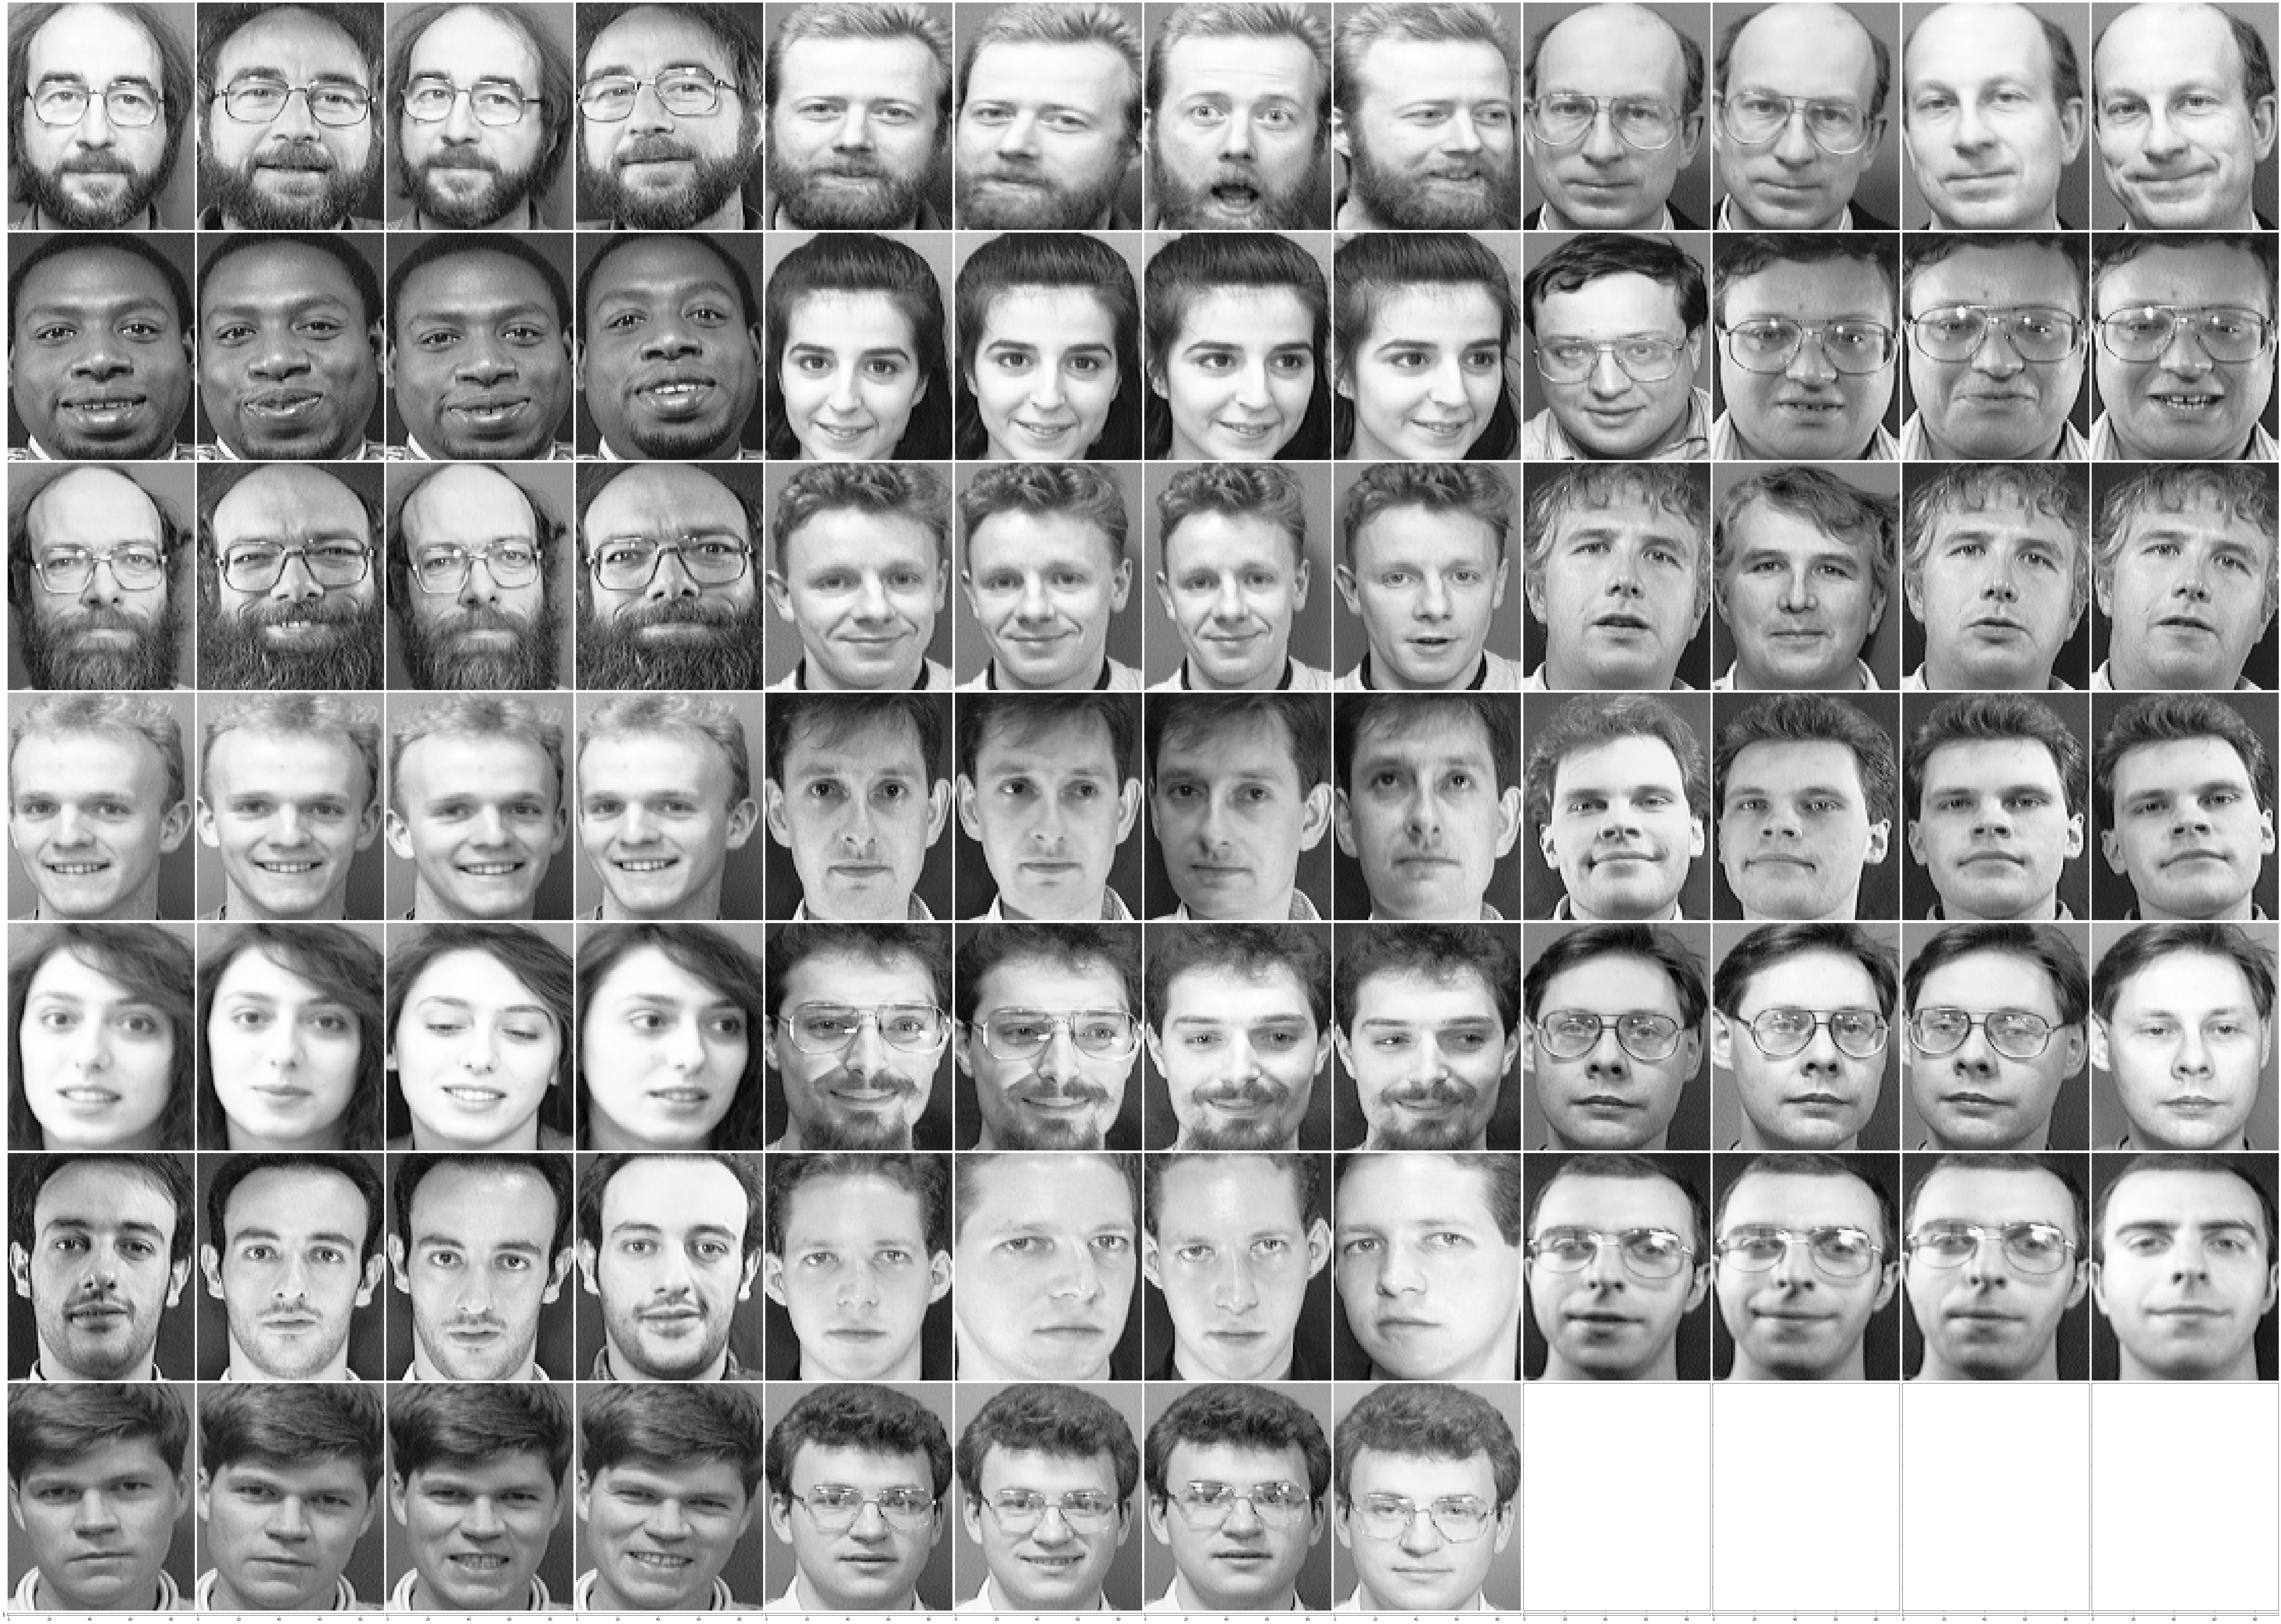

In [4]:
render_images(face_matrix)

The faces are now in the `face_matrix`. Each column is a face. Now, let's compute the ***mean face***.

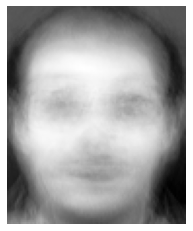

In [5]:
mean_face = np.zeros(shape = (NM,), dtype = float)

for face in face_matrix.T:
    mean_face += face
        
mean_face /= face_matrix.shape[1]

image = mean_face.reshape((M, N))
render_image(image)

Above you can see what the mean face looks like. Let's subtract it from the other faces, to **center the data**.

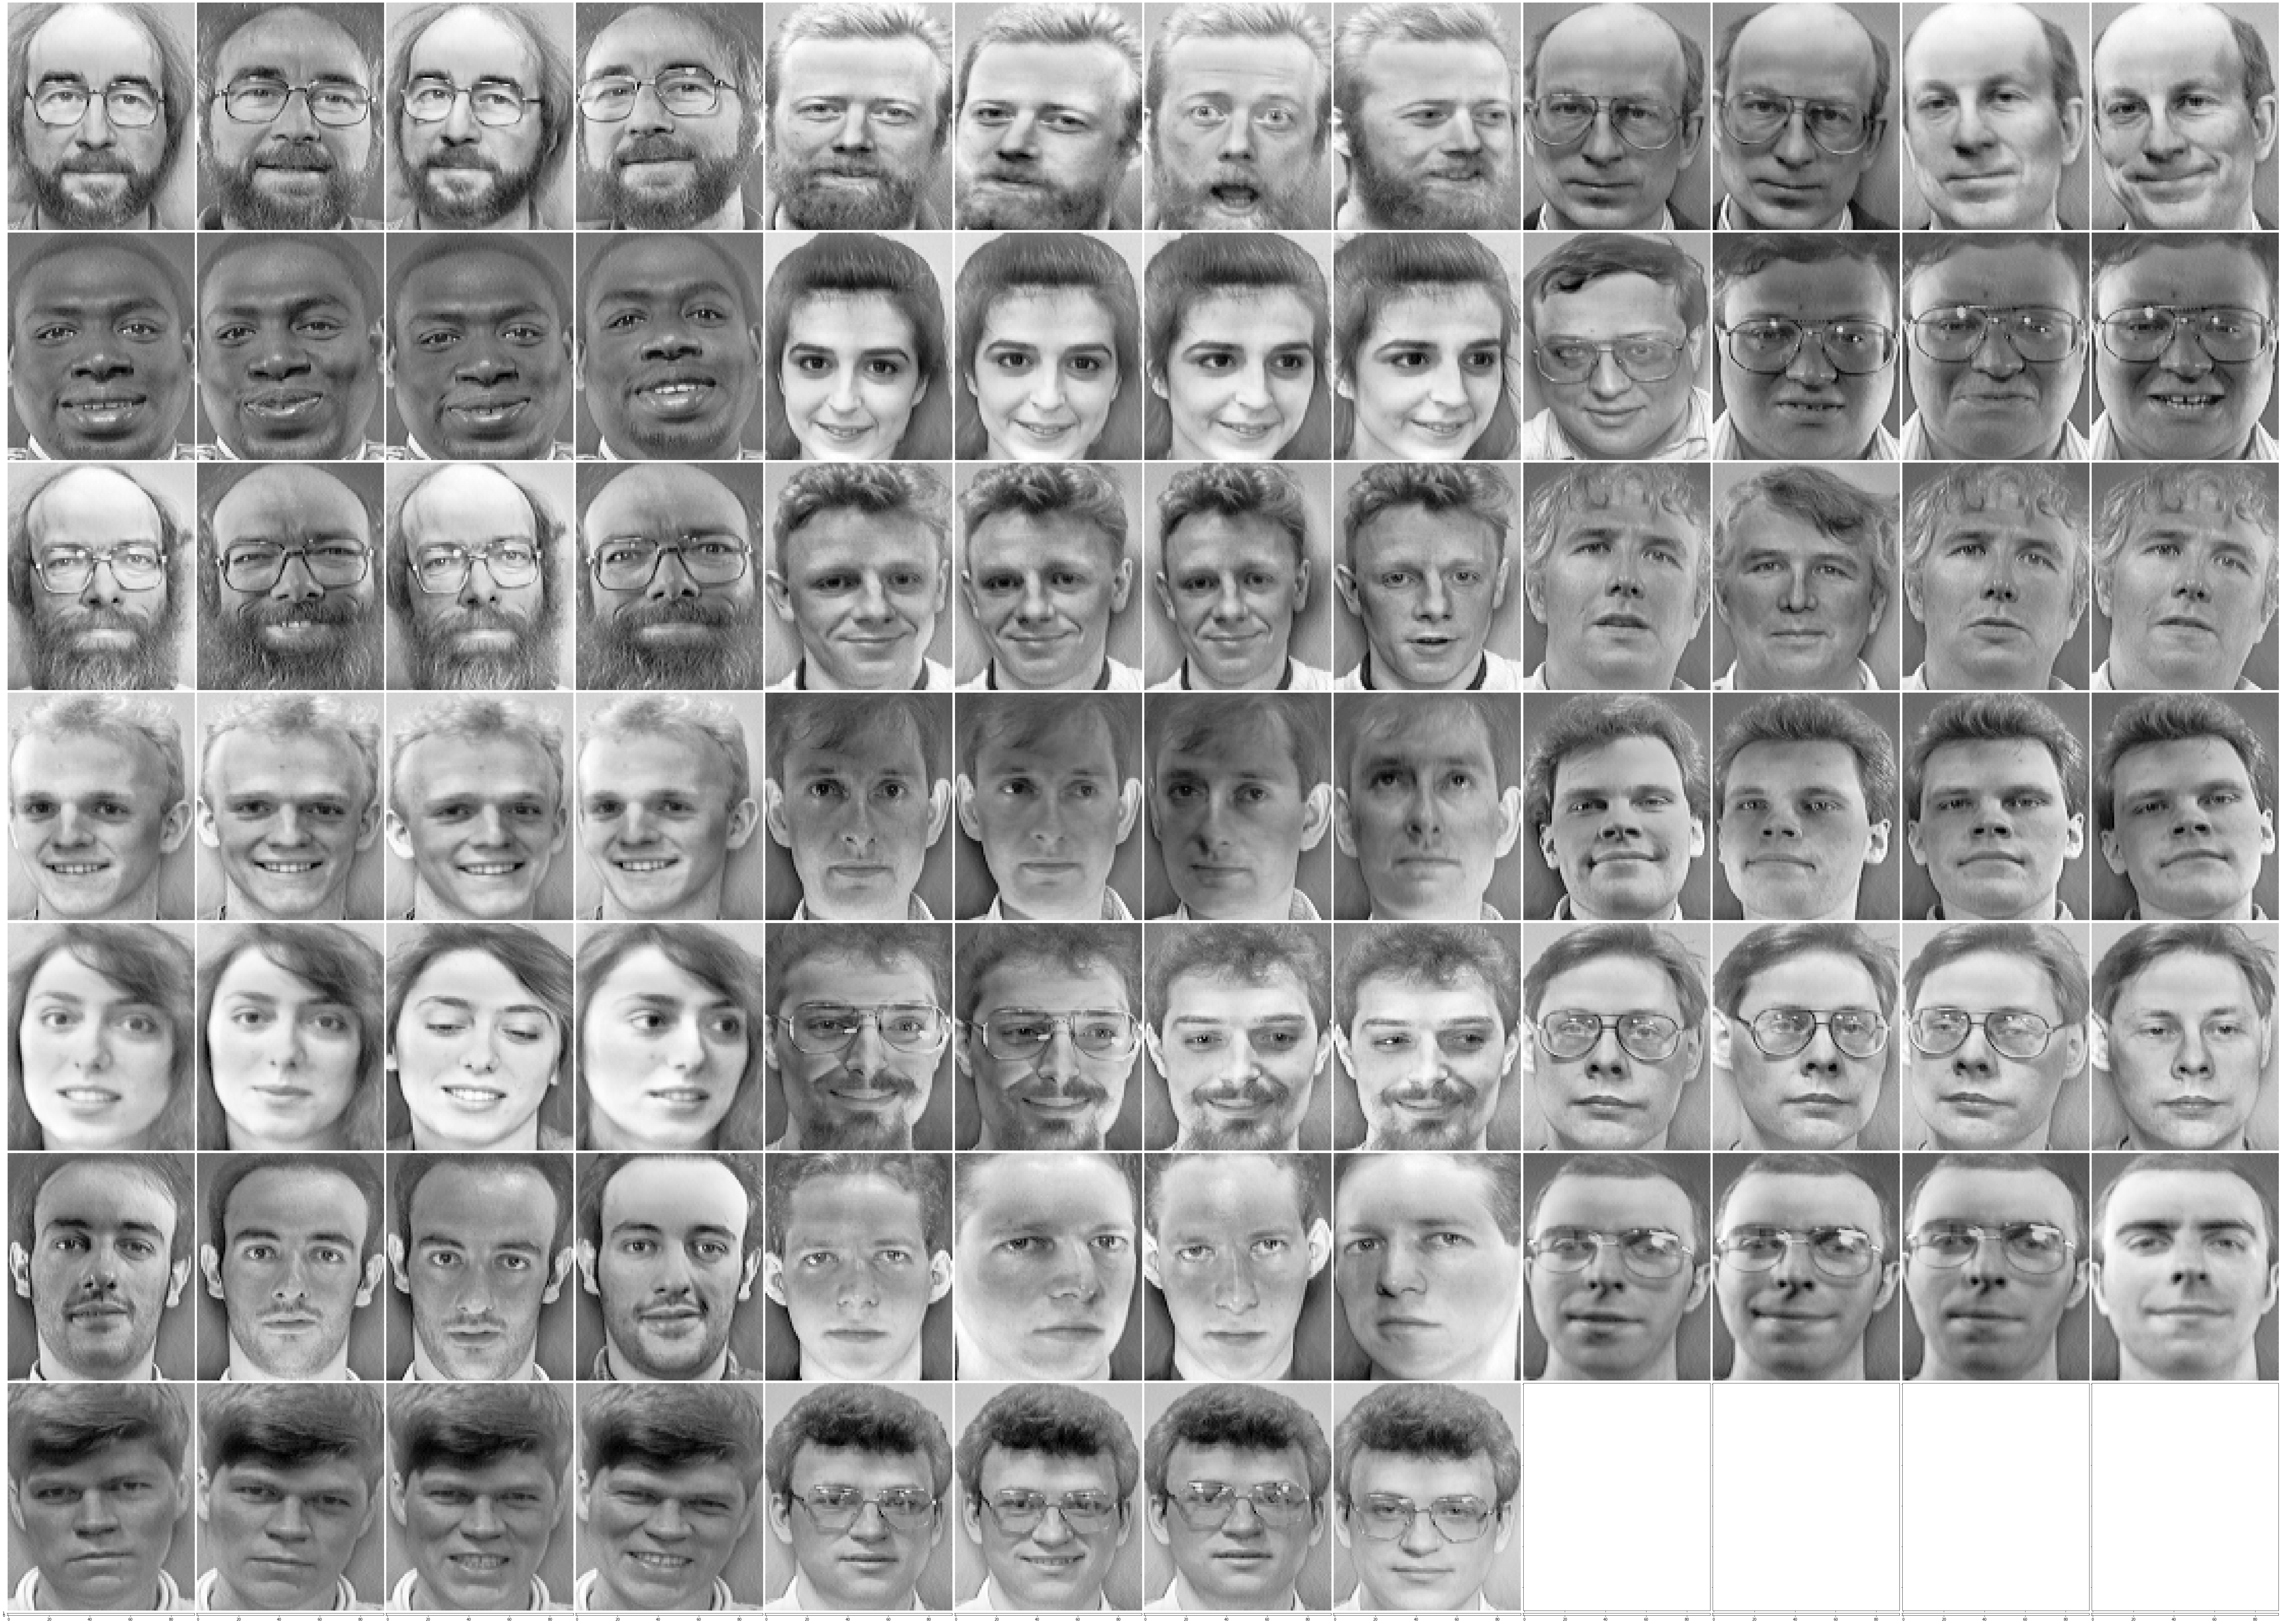

In [6]:
for i in range(0, face_matrix.shape[1]):
    face_matrix[:, i] -= mean_face

render_images(face_matrix)

And now, let's calculate our *eigenfaces*. They would, supposedly, be the eigenvectors of the covariance matrix of our `face_matrix`, ***A***, but we'll use a little trick: since the covariance matrix, ***C***, would be huge *((NxM)^2 x (NxM)^2)*, we will compute the eigenvectors of a smaller matrix, that we'll call `L_matrix` in the code. 

To understand why this works, see the math below.

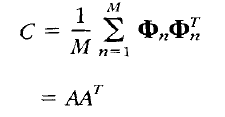

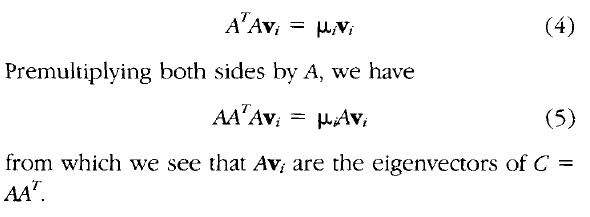

In [7]:
L_matrix = face_matrix.T @ face_matrix
eigenvalues, eigenvectors = la.eig(L_matrix)

eigenfaces = np.zeros(shape = face_matrix.shape, dtype = float)

for i in range(face_matrix.shape[1]):
    eigenfaces[:, i] = face_matrix @ eigenvectors[:, i]

Let's see what our (not so pretty) eigenfaces look like.

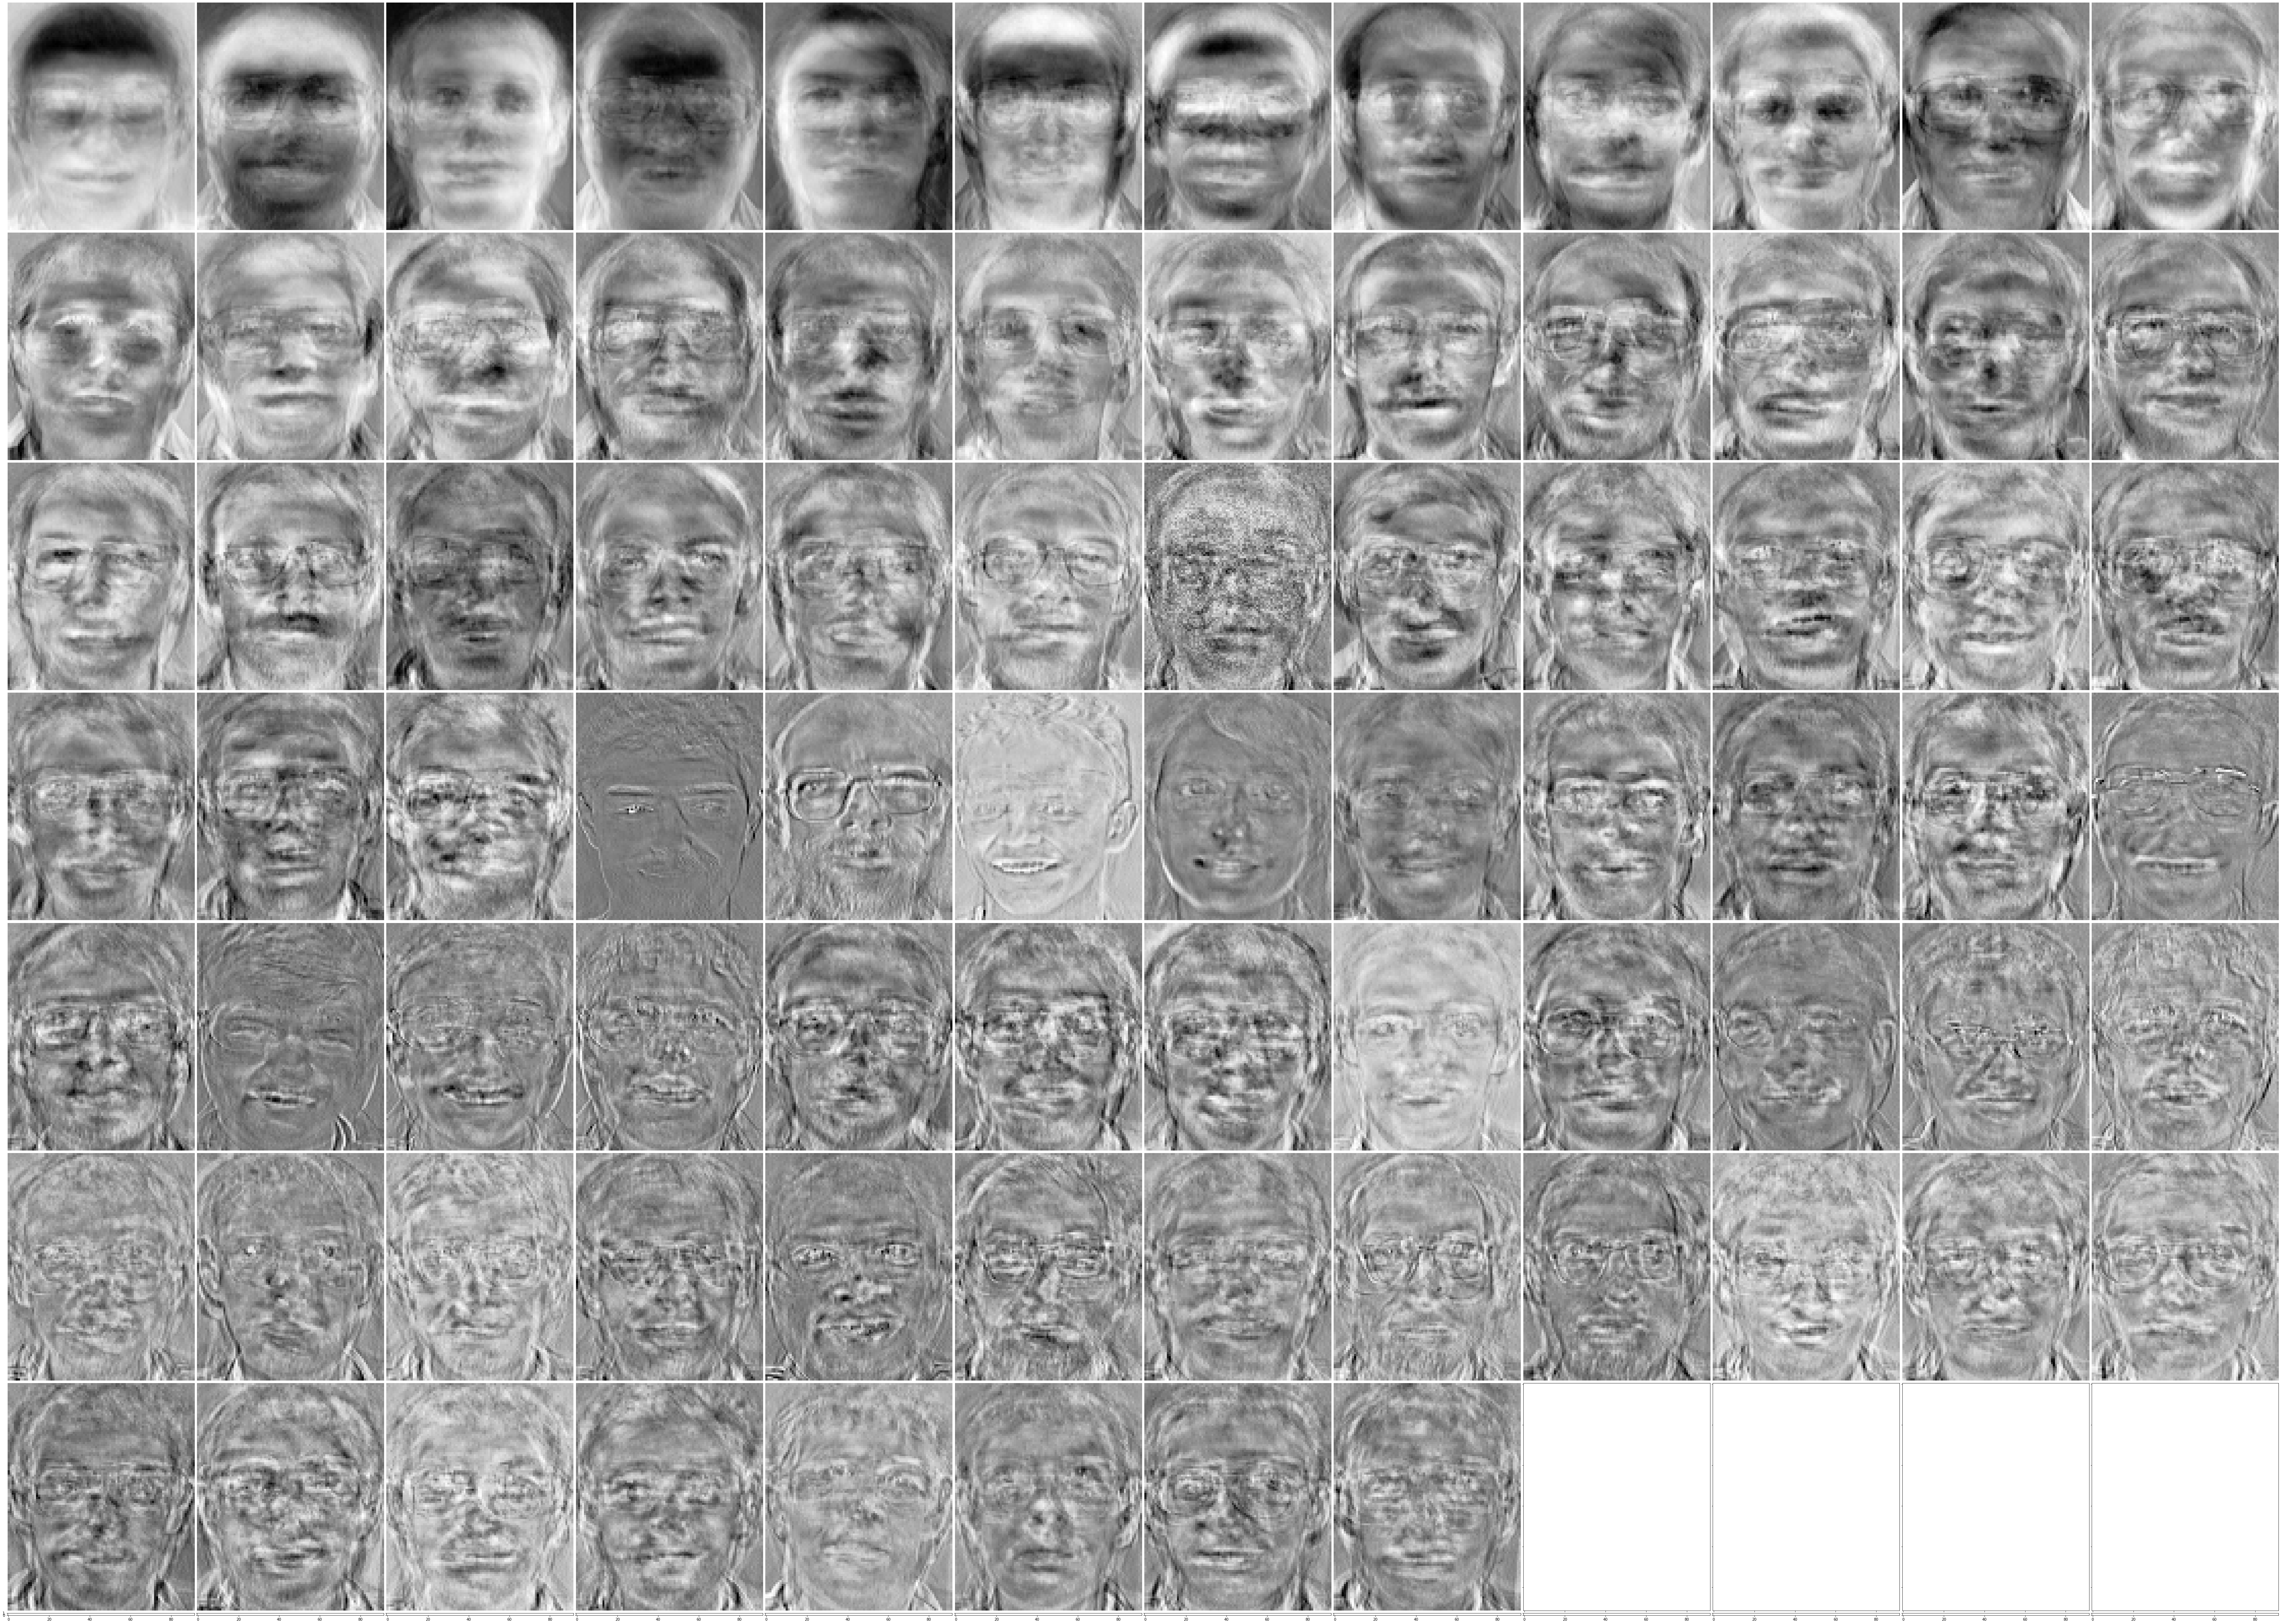

In [8]:
render_images(eigenfaces)

Now, let's get the eigenfaces that represent 95% of the variance in the dataset. These will be the basis of the ***face space***.

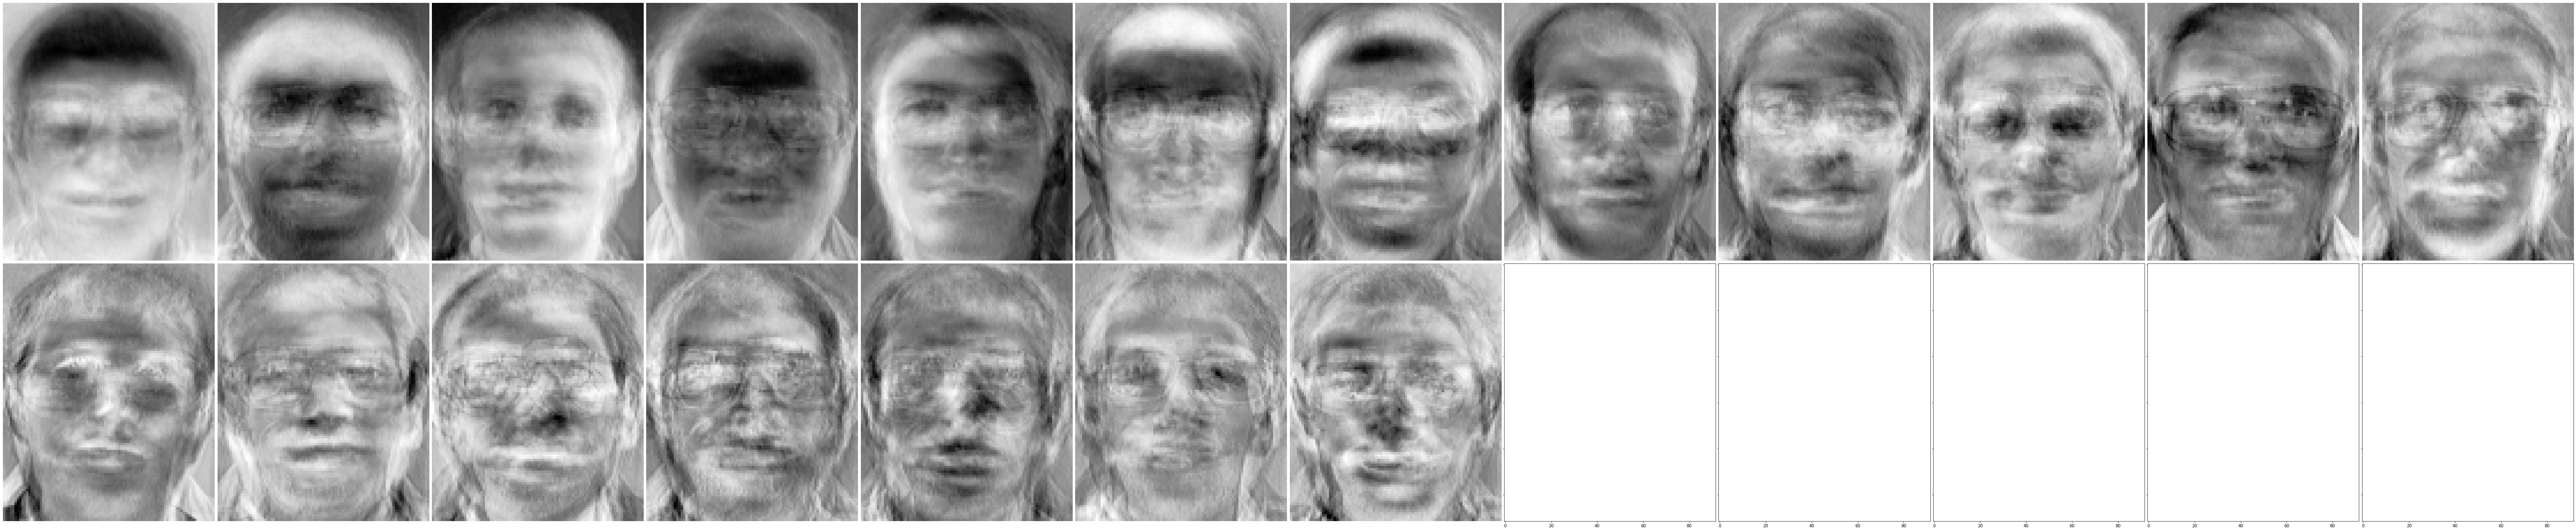

In [9]:
def get_varN_eigenfaces(target_variance:int, evalues: np.ndarray, efaces: np.ndarray):
    def get_Nvar_indices():
        top_indices = eigenvalues.argsort()
        eig_total = eigenvalues.sum()
        c_sum = 0
        faces = []
    
        for i in reversed(top_indices):
            c_sum += eigenvalues[i]
            variance = c_sum / eig_total
            faces += [i]
        
            if variance > target_variance:
                break
        return faces
    
    if target_variance > 1 or target_variance < 0:
        raise ValueError("Variance must be in [0, 1].")
    
    indices = get_Nvar_indices()
    
    varN_eigenfaces = np.zeros((NM, len(indices)), dtype = float)
    
    for i, j in list(enumerate(indices)):
        varN_eigenfaces[:, i] = eigenfaces[:, j]
                
    return varN_eigenfaces

basis_eigenfaces = get_varN_eigenfaces(.80, eigenvalues, eigenfaces)
render_images(basis_eigenfaces)

## Recognition

To recognize the face of a known individual, we need to create a ***face class*** — an average of the individual's known *eigenface representations* (the individual's face using the eigenfaces as basis vectors). These can be seen as the centroids of the faces of an individual.

After that, whenever we receive an input image and center it, we shall measure the distance of its *eigenface representation* to each ***face class***. If the distance between the *eigenface representation* of the image to a face class, and the distance between the original centered image is below some threshold, then we can try to recognize it; otherwise, it's an unknown face.
    
Let's create the *face classes* first.

In [10]:
rand_ids_not_in_training_set = rng.choice([x for x in range(1, 41) if x not in training_set_ids],
                                            size = 8,
                                            replace = False)

rand_ids_from_training_set = rng.choice(training_set_ids, size = 8, replace = False)

test_set_ids = np.concatenate((rand_ids_not_in_training_set, rand_ids_from_training_set))

def get_weights_vector(image: np.ndarray):
    return basis_eigenfaces.T @ image

def compute_face_class(class_index: int):
    face_class = np.zeros((basis_eigenfaces.shape[1],), dtype = float)
    
    for i in range(1, 10):
        image_vector = get_img(get_training_path_to_img(class_index, i))
        image_vector -= mean_face
        face_class += get_weights_vector(image_vector)
    face_class /= 9
    
    return face_class

face_classes = {}
for i in training_set_ids:
    face_classes[i] = compute_face_class(i)

Now that we have our *face classes*, we can start receiving input images. But first, let's define function to compute the distance to the *face classes*, and define the threshold for the acceptable distance to a *face class*.

In [11]:
def distance_to_face_class(kth_class: int, weights_vector: np.ndarray):
    return la.norm(weights_vector - face_classes[kth_class])

threshold = 0

def set_threshold(theta: float):
    global threshold
    threshold = theta

interact(set_threshold, 
         theta = widgets.FloatLogSlider(
             value = 10e6,
             base = 10,
             min = 6,
             max = 12,
             step = .1,
             description = "threshold"
         ))

interactive(children=(FloatLogSlider(value=10000000.0, description='threshold', max=12.0, min=6.0), Output()),…

<function __main__.set_threshold(theta: float)>

Now, let's use a set of sixteen images: eight from the training set and eight from outside the training set, and see the results!

Threshold:  15848931.924611142
Training ids:  [13 28 10 17 15 24 26 19]
Ids not in training set:  [23  7 27 39 29 40  3 20]

Image 23 is an unknown subject!
Image 7 is an unknown subject!
Image 27 is an unknown subject!
Image 39 is an unknown subject!
Image 29 is an unknown subject!
Image 40 is an unknown subject!
Image 3 is subject 4!
Image 20 is an unknown subject!
Image 13 is subject 13!
Image 28 is an unknown subject!
Image 10 is an unknown subject!
Image 17 is subject 36!
Image 15 is an unknown subject!
Image 24 is subject 24!
Image 26 is subject 26!
Image 19 is subject 19!


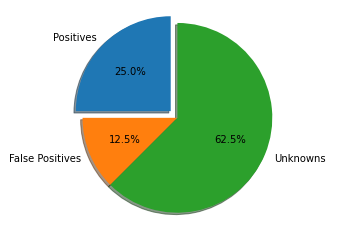

In [15]:
print("Threshold: ", threshold)        
print("Training ids: ", rand_ids_from_training_set)
print("Ids not in training set: ", rand_ids_not_in_training_set, end="\n\n")

positives = 0
false_positives = 0
unknown_faces = 0
not_a_faces = 0

# Returns (class, distance)
def get_closest_face_class(weights_vector: np.ndarray):
    ret_class = 0
    min_dist = float('inf')
    
    for k in face_classes:
        dist = distance_to_face_class(k, weights_vector)
        if (dist < min_dist):
            min_dist = dist
            ret_class = k
            
    return ret_class, min_dist

# Tries to recognize the image with the given weights.
def try_to_recognize_image(weights_vector: np.ndarray, image_id: int):
    k, dist_to_a_face_class = get_closest_face_class(weights_vector)
    if dist_to_a_face_class < threshold:
        print("Image {} is subject {}!".format(image_id, k))
        
        if image_id != k:
            return "FP"
        else:
            return "P"
            
    elif dist_to_a_face_class >= threshold:
        print("Image {} is an unknown subject!".format(image_id))
        return "UNK"
        
# Recognition loop
for i in test_set_ids:
    path_to_img = get_testing_path_to_img(i)
    image_vector = get_img(path_to_img)
    image_vector -= mean_face
    
    weights_vector = get_weights_vector(image_vector)
        
    res = try_to_recognize_image(weights_vector, i)
    
    if res == "P":
        positives += 1
    elif res == "FP":
        false_positives += 1
    elif res == "UNK":
        unknown_faces += 1
    
    
# Shows a pie graph of the results
        
labels = ["Positives", "False Positives", "Unknowns"]
fig1, ax1 = plt.subplots()
ax1.pie([positives, false_positives, unknown_faces],
        labels=labels,
        explode=(.1, 0, 0),
        autopct='%1.1f%%',
        shadow=True,
        rotatelabels=False,
        startangle=90)

ax1.axis('equal')

plt.show()